<h1>第一部份</h1>

In [237]:
import pandas as pd

# 讀取CSV文件
df = pd.read_csv("C:\\Users\\Modern 14\\Desktop\\codementorTest\\person\\fn01_table_person__merged_output.csv")
# df = pd.read_csv(r"C:\pythonpractice\thesis\link_0ibrahimyilmaz.csv")
# df.fillna(0, inplace=True)

# 篩選出評論數大於等於29的鏈接################
link_counts = df['link'].value_counts()
df = df[df['link'].isin(link_counts[link_counts >= 20].index)]
############################################


# 將日期格式轉換為datetime
df['time'] = pd.to_datetime(df['time'])
############################################
# 將日期修改為該月的第一天
df['time'] = df['time'].dt.to_period('M').dt.to_timestamp()
############################################

############################################
# 找到所有缺失的鏈接
zero_review_links = df.groupby('link')['p_job'].apply(lambda x: x.isnull().all() or x.nunique() == 1)
zero_review_links.sort_index(inplace=True)

# 剔除所有評論都為零的鏈接
df = df[~df['link'].isin(zero_review_links[zero_review_links].index)]
# df=(df.set_index('time')
#    .groupby('link', as_index=False)
#    .apply(lambda d: d.reindex(pd.date_range(d.index.min(), d.index.max(), freq='MS')))
#    .interpolate(method='linear')
#    .ffill()
#    .reset_index(level=0, drop=True)
# )

df = df.set_index(['link', 'time'])

# 重新索引以填充缺失的時間點
idx = pd.MultiIndex.from_product([df.index.levels[0], pd.date_range(df.index.levels[1].min(), df.index.levels[1].max(), freq='MS')])
df = df.reindex(idx)

# 使用前一個非空值填充缺失的值
df = df.bfill()


df.reset_index(inplace=True)
# df.rename(columns = {'index':'time'}, inplace = True) ##20240410
df.rename(columns = {'level_1':'time'}, inplace = True) 


In [238]:
df[df['link']=='/@kosicn']

,link,time,p_picture_label,p_star,p_review,p_money,p_job,p_message_label_count,p_message_First_15,p_message_Featured_Mentor,p_message_Facebook
26158,/@kosicn,2021-02-01,https://ucarecdn.com/bd7117a8-30d6-4958-aad1-d...,5.0,1.0,10.0,2.0,1.0,1.0,0.0,0.0
26159,/@kosicn,2021-03-01,https://ucarecdn.com/bd7117a8-30d6-4958-aad1-d...,5.0,1.0,10.0,2.0,1.0,1.0,0.0,0.0
26160,/@kosicn,2021-04-01,https://ucarecdn.com/bd7117a8-30d6-4958-aad1-d...,5.0,1.0,10.0,2.0,1.0,1.0,0.0,0.0
26161,/@kosicn,2021-05-01,https://ucarecdn.com/bd7117a8-30d6-4958-aad1-d...,5.0,1.0,10.0,2.0,1.0,1.0,0.0,0.0
26162,/@kosicn,2021-06-01,https://ucarecdn.com/bd7117a8-30d6-4958-aad1-d...,5.0,1.0,10.0,2.0,1.0,1.0,0.0,0.0
26163,/@kosicn,2021-07-01,https://ucarecdn.com/bd7117a8-30d6-4958-aad1-d...,5.0,1.0,10.0,2.0,1.0,1.0,0.0,0.0
26164,/@kosicn,2021-08-01,https://ucarecdn.com/bd7117a8-30d6-4958-aad1-d...,5.0,1.0,10.0,3.0,1.0,1.0,0.0,0.0
26165,/@kosicn,2021-09-01,https://ucarecdn.com/bd7117a8-30d6-4958-aad1-d...,5.0,1.0,10.0,3.0,1.0,1.0,0.0,0.0
26166,/@kosicn,2021-10-01,https://ucarecdn.com/bd7117a8-30d6-4958-aad1-d...,5.0,1.0,15.0,3.0,1.0,1.0,0.0,0.0
26167,/@kosicn,2021-11-01,https://ucarecdn.com/bd7117a8-30d6-4958-aad1-d...,5.0,1.0,15.0,6.0,1.0,1.0,0.0,0.0


<h1 align = 'center'>計算基數與成長差距 </h1>

In [10]:
from scipy.stats import gmean


# Step 1: 計算每個連結的第一期
first_period_p_job = df[df.groupby('link')['time'].transform('min') == df['time']][['link', 'p_job']]
first_period_p_job.rename(columns={'p_job': 'first_period_p_job'}, inplace=True)

# Step 2: 計算每個連結的 p_job 最後一期與第一期的差距

p_job_diff = df.groupby('link')['p_job'].apply(lambda x: (x.iloc[-1] - x.iloc[0])).reset_index()
p_job_diff.columns = ['link', 'p_job_diff']
result_df = pd.merge(first_period_p_job, p_job_diff, on='link')


# # Step 3: 計算每個連結的 p_job 成長率
# p_job_growthRate = df.groupby('link')['p_job'].apply(lambda x: (x.iloc[-1] - x.iloc[0])/x.iloc[0]).reset_index()
# p_job_growthRate.columns = ['link', 'p_job_growthRate']
# result_df = pd.merge(first_period_p_job, p_job_growthRate, on='link')


## Step 6: 篩選出 p_job_diff 大於等於0的連結
result_df=result_df[result_df['p_job_diff'] >=1]



In [13]:
# result_df[result_df['link'] == '/@a.k']   

result_df.sort_values(by='p_job_diff', ascending=False, inplace=True)
result_df

,link,first_period_p_job,p_job_diff
477,/@e4c5,3154.0,1892.0
862,/@kalaiselvid,52.0,1729.0
1303,/@rajharajesuwari,1581.0,1676.0
351,/@coffeetocode,1377.0,1582.0
1524,/@stefangeorg,2398.0,1401.0
...,...,...,...
524,/@evereq,11.0,1.0
1065,/@michaelzomparelli614,4.0,1.0
1528,/@stephenbunch,11.0,1.0
1322,/@raymondarteagasanchez,1.0,1.0


<h1 align ='center'>畫出成長數量散布圖</h1>

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

result_df['p_job_diff'] = np.where(result_df['p_job_diff'] <= 0, np.nan, result_df['p_job_diff'])
# 對 'p_job_first' 列取對數，NaN 將被保留為 NaN
result_df['log_p_job_diff'] = np.log(result_df['p_job_diff'])


# 對 'p_job_first' 列取對數
result_df['log_p_job_first'] = np.log(result_df['first_period_p_job'])


plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# selected_features = ['p_star', 'p_review', 'p_money', 'p_job', 'p_message_label_count', 'p_message_First_15', 'p_message_Featured_Mentor', 'p_message_Facebook', 'review_growth_per_link', 'percentile_rank']
selected_features = ['log_p_job_first','log_p_job_diff']

# K-means叢集分析
kmeans = KMeans(n_clusters=4, random_state=42)
result_df['cluster'] = kmeans.fit_predict(result_df[selected_features])

# 繪製散點圖
centers = kmeans.cluster_centers_
plt.scatter(result_df['log_p_job_first'], result_df['log_p_job_diff'], c=result_df['cluster'], cmap='viridis', label='Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.xlabel('第一期基數')
plt.ylabel('成長數量')

plt.title('第一期基數與成長數量')
# plt.xlabel('percentile_rank')
# plt.ylabel('review_growth_per_link (Standardized)')
plt.legend(title='Clusters', loc='upper right')
plt.show()



NameError: name 'result_df' is not defined

c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


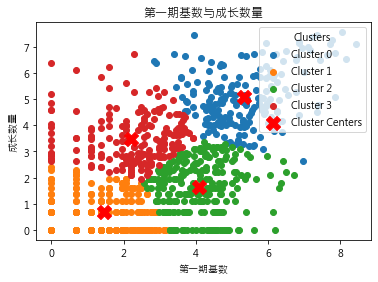

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

result_df['p_job_diff'] = np.where(result_df['p_job_diff'] <= 0, np.nan, result_df['p_job_diff'])
# 对 'p_job_first' 列取对数，NaN 将被保留为 NaN
result_df['log_p_job_diff'] = np.log(result_df['p_job_diff'])

# 对 'p_job_first' 列取对数
result_df['log_p_job_first'] = np.log(result_df['first_period_p_job'])

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 选取特征
selected_features = ['log_p_job_first','log_p_job_diff']

# K-means聚类分析
kmeans = KMeans(n_clusters=4, random_state=42)
result_df['cluster'] = kmeans.fit_predict(result_df[selected_features])

# 绘制散点图
centers = kmeans.cluster_centers_
for cluster_label in range(4):
    cluster_data = result_df[result_df['cluster'] == cluster_label]
    plt.scatter(cluster_data['log_p_job_first'], cluster_data['log_p_job_diff'], label=f'Cluster {cluster_label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.xlabel('第一期基数')
plt.ylabel('成长数量')

plt.title('第一期基数与成长数量')
plt.legend(title='Clusters', loc='upper right')
plt.show()


<h1 align="center">標準化後結果</h1>

c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


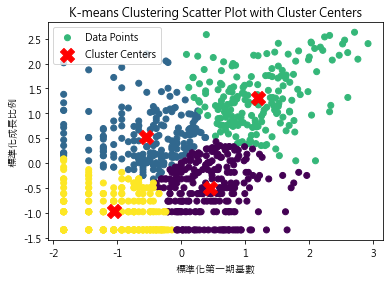

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 選擇要標準化的特徵
selected_features = ['log_p_job_first', 'log_p_job_diff']

# 創建 StandardScaler 對象
scaler = StandardScaler()

# 對選擇的特徵進行標準化
scaled_features = scaler.fit_transform(result_df[selected_features])

# K-means叢集分析
kmeans = KMeans(n_clusters=4, random_state=42)
result_df['cluster'] = kmeans.fit_predict(scaled_features)

# 繪製散點圖
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=result_df['cluster'], cmap='viridis', label='Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.title('K-means Clustering Scatter Plot with Cluster Centers')
plt.xlabel('標準化第一期基數')
plt.ylabel('標準化成長比例')
plt.legend()
plt.show()


<h1 align="center">-----------------分隔線--------------------</h1>

In [5]:
import pandas as pd

import numpy as np
# 讀取CSV文件
# df = pd.read_csv("C:\\Users\\Modern 14\\Desktop\\codementorTest\\person\\fn01_table_person__merged_output.csv")
df = pd.read_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\merged_output.csv")

#*******修改********
# 篩選出評論數大於等於10的鏈接
link_counts = df['link'].value_counts()
df = df[df['link'].isin(link_counts[link_counts >= 10].index)]

# 將日期格式轉換為datetime
df['time'] = pd.to_datetime(df['time'])

# 將日期修改為該月的第一天
df['time'] = df['time'].dt.to_period('M').dt.to_timestamp()

# 找到所有缺失的鏈接
zero_review_links = df.groupby('link')['p_job'].apply(lambda x: x.isnull().all() or x.nunique() == 1)
zero_review_links.sort_index(inplace=True)

# 剔除所有評論都為零的鏈接
df = df[~df['link'].isin(zero_review_links[zero_review_links].index)]

# # 重新索引並填充缺失值
# df = (df.set_index('time')
#       .groupby('link', as_index=False)
#       .apply(lambda d: d.reindex(pd.date_range(d.index.min(), d.index.max(), freq='MS')))
#       .interpolate(method='linear')
#       .ffill()
#       .reset_index(level=0, drop=True)
# )
# # 重設索引
# df.reset_index(inplace=True)
# df.rename(columns={'index': 'time'}, inplace=True)


df = df.set_index(['link', 'time'])

# 重新索引以填充缺失的時間點
idx = pd.MultiIndex.from_product([df.index.levels[0], pd.date_range(df.index.levels[1].min(), df.index.levels[1].max(), freq='MS')])
df = df.reindex(idx)

# 使用前一個非空值填充缺失的值
df = df.bfill()

df.reset_index(inplace=True)
# df.rename(columns = {'index':'time'}, inplace = True) ##20240410
df.rename(columns = {'level_1':'time'}, inplace = True) 


# 創建一個字典來儲存每個數值型變數的第一期值和最後一期值
diff_dict = {}

## 獲取 p_job 的第一期和最後一期的值
first_value = df.groupby('link')['p_job'].first()
last_value = df.groupby('link')['p_job'].last()
diff_dict['p_job' + '_first'] = first_value
diff_dict['p_job' + '_diff'] = (last_value - first_value)
############################################

## 獲取 p_star, p_review, p_money 的 max-min 差值
growth_columns = ['p_star', 'p_review', 'p_money', 'em_count', 'ex_count', 'pro_count', 're_count', 'a_headline_count', 'headline_readability', 'a_about_count', 'about_readability']

for col in growth_columns:
    max_value = df.groupby('link')[col].max()
    min_value = df.groupby('link')[col].min()
    avg_value = df.groupby('link')[col].mean()
    first_value = df.groupby('link')[col].first()
    diff_dict[col + '_diff'] = (max_value - min_value)
    # diff_dict[col + '_avg'] = avg_value
    diff_dict[col + '_first'] = first_value
############################################

## 獲取其他數值型變數的最大值   
numeric_columns = df.select_dtypes(include='number').columns.tolist()
remove_columns = ['p_job','p_star', 'p_review', 'p_money', 'em_count', 'ex_count', 'pro_count', 're_count', 'a_headline_count', 'headline_readability', 'a_about_count', 'about_readability']

for col in remove_columns:
    numeric_columns.remove(col)
for col in numeric_columns:
    max_value = df.groupby('link')[col].max()
    diff_dict[col] = (max_value)
############################################
    

## 計算每個變數的第一期和最後一期的差距、增長率
# for col in numeric_columns:
#     first_value = df.groupby('link')[col].first()
#     last_value = df.groupby('link')[col].last()
#     diff_dict[col + '_diff'] = (last_value - first_value)
#     # diff_dict[col + '_first'] = first_value
#     # diff_dict[col + '_growth'] = (last_value - first_value) / first_value
############################################
    


# 將字典轉換為DataFrame
diff_df = pd.DataFrame(diff_dict).reset_index()

# 對 'p_job_first' 和 'p_job_diff' 列取對數
diff_df[['log_p_job_first', 'log_p_job_diff']] = np.log(diff_df[['p_job_first', 'p_job_diff']])

# 重命名列名
diff_df.rename(columns={'index': 'link'}, inplace=True)

#*******修改********
# 篩選出 p_job_diff 大於等於0的連結
diff_df = diff_df[diff_df['p_job_diff'] >= 0]

# 將 'p_job_diff' 列取對數
diff_df['log_p_job_diff'] = np.log1p(diff_df['p_job_diff'])

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


check area

c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-pac

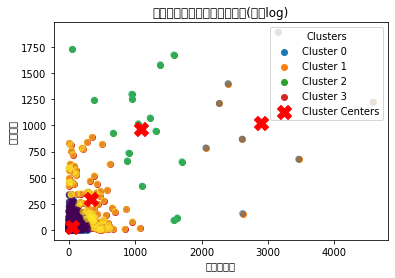

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt




# 提取需要用於聚類的特徵
X = diff_df[['p_job_first', 'p_job_diff']]

# 創建 K-means 聚類器
kmeans = KMeans(n_clusters=4, random_state=42)

# 進行聚類
diff_df['cluster'] = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_
for cluster_label in range(4):
    cluster_data = diff_df[diff_df['cluster'] == cluster_label]
    plt.scatter(cluster_data['p_job_first'], cluster_data['p_job_diff'], label=f'Cluster {cluster_label}')

# 繪製聚類結果的散點圖
plt.scatter(diff_df['p_job_first'], diff_df['p_job_diff'], c=diff_df['cluster'], cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('第一期基數與成長數量散佈圖(未取log)')
plt.xlabel('第一期基數')
plt.ylabel('成長數量')
plt.legend(title='Clusters', loc='upper right')
plt.show()


In [294]:
# diff_df.columns

Index(['link', 'p_job_first', 'p_job_diff', 'p_star_diff', 'p_star_first',
       'p_review_diff', 'p_review_first', 'p_money_diff', 'p_money_first',
       'em_count_diff', 'em_count_first', 'ex_count_diff', 'ex_count_first',
       'pro_count_diff', 'pro_count_first', 're_count_diff', 're_count_first',
       'a_headline_count_diff', 'a_headline_count_first',
       'headline_readability_diff', 'headline_readability_first',
       'a_about_count_diff', 'a_about_count_first', 'about_readability_diff',
       'about_readability_first', 'p_message_label_count',
       'p_message_First_15', 'p_message_Featured_Mentor', 'p_message_Facebook',
       'video', 'language_eng', 'language_hindi', 'c', 'social_link_count',
       'github_label', 'stackoverflow_label', 'twitter_label',
       'linkedin_label', 'log_p_job_first', 'log_p_job_diff', 'cluster'],
      dtype='object')

c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


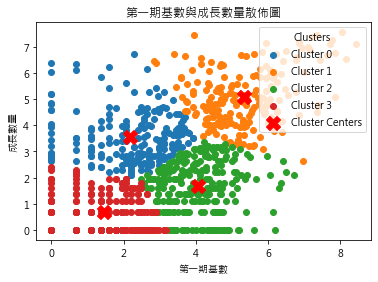

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

diff_df['p_job_diff'] = np.where(diff_df['p_job_diff'] <= 0, np.nan, diff_df['p_job_diff'])
# 对 'p_job_first' 列取对数，NaN 将被保留为 NaN
diff_df['log_p_job_diff'] = np.log(diff_df['p_job_diff'])

# 对 'p_job_first' 列取对数
diff_df['log_p_job_first'] = np.log(diff_df['p_job_first'])

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 选取特征
selected_features = ['log_p_job_first','log_p_job_diff']
diff_df.dropna(inplace=True)
# K-means聚类分析
kmeans = KMeans(n_clusters=4, random_state=42)
diff_df['cluster'] = kmeans.fit_predict(diff_df[selected_features])

# 绘制散点图
centers = kmeans.cluster_centers_
for cluster_label in range(4):
    cluster_data = diff_df[diff_df['cluster'] == cluster_label]
    plt.scatter(cluster_data['log_p_job_first'], cluster_data['log_p_job_diff'], label=f'Cluster {cluster_label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.xlabel('第一期基數')
plt.ylabel('成長數量')

plt.title('第一期基數與成長數量散佈圖')
plt.legend(title='Clusters', loc='upper right')
plt.show()


In [8]:
diff_df.to_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\20240603\diff_df20240603.csv", index=False)

<h3>建立cluster分類</h3>

In [16]:
import numpy as np

# 找到 p_job_diff 列的 75 分位數
p_job_diff_75th_percentile = np.percentile(diff_df['p_job_diff'], 75)

# 根據條件設置 cluster75 列的值
diff_df['cluster75'] = np.where(diff_df['p_job_diff'] > p_job_diff_75th_percentile, 1, 0)
diff_df['cluster10'] = np.where(diff_df['p_job_diff'] > 10, 1, 0)

In [91]:
# diff_df.columns

Index(['link', 'p_job_first', 'p_job_diff', 'p_star_diff', 'p_star_first',
       'p_review_diff', 'p_review_first', 'p_money_diff', 'p_money_first',
       'em_count_diff', 'em_count_first', 'ex_count_diff', 'ex_count_first',
       'pro_count_diff', 'pro_count_first', 're_count_diff', 're_count_first',
       'a_headline_count_diff', 'a_headline_count_first',
       'headline_readability_diff', 'headline_readability_first',
       'a_about_count_diff', 'a_about_count_first', 'about_readability_diff',
       'about_readability_first', 'p_message_label_count',
       'p_message_First_15', 'p_message_Featured_Mentor', 'p_message_Facebook',
       'video', 'language_eng', 'language_hindi', 'c', 'social_link_count',
       'github_label', 'stackoverflow_label', 'twitter_label',
       'linkedin_label', 'log_p_job_first', 'log_p_job_diff', 'cluster',
       'cluster75', 'cluster10'],
      dtype='object')

建立3種不同的 social capital dataframe

In [10]:
##建立embodied_df 
embodied_column = ['link', 'p_message_label_count', 'a_headline_count_diff', 'headline_readability_diff', 'a_about_count_diff','about_readability_diff','language_eng','language_hindi','c','cluster','cluster75','cluster10']
diff_columns = [col for col in embodied_column if col.endswith('_diff')]
for col_diff in diff_columns:
    col_first = col_diff.replace('_diff', '_first')
    embodied_column.append(col_first)
    # col_avg = col_diff.replace('_diff', '_avg')
    # embodied_column.append(col_avg)
    embodied_column = [col for col in embodied_column if not col.endswith('_diff')]
embodied_df = diff_df[embodied_column].copy()
embodied_df = embodied_df.reindex(sorted(embodied_df.columns), axis=1)
############################################

##建立objectified_df
objectified_column = ['link', 'p_star_diff', 'p_review_diff', 'p_money_diff', 'em_count_diff', 'ex_count_diff', 'pro_count_diff', 're_count_diff','cluster','cluster75','cluster10']
diff_columns = [col for col in objectified_column if col.endswith('_diff')]
for col_diff in diff_columns:
    col_first = col_diff.replace('_diff', '_first')
    objectified_column.append(col_first)
    objectified_column = [col for col in objectified_column if not col.endswith('_diff')]
    # col_avg = col_diff.replace('_diff', '_avg')
    # objectified_column.append(col_avg)
objectified_df = diff_df[objectified_column].copy()

objectified_df = objectified_df.reindex(sorted(objectified_df.columns), axis=1)
############################################

##建立merged_df
#20240411
institutionalized_column = ['link','p_message_First_15' ,'p_message_Featured_Mentor', 'p_message_Facebook','social_link_count','stackoverflow_label','github_label','twitter_label','linkedin_label','p_job_diff','p_job_first','cluster','cluster75','cluster10']
#20240410
# institutionalized_column = ['link','p_message_First_15' ,'p_message_Featured_Mentor', 'p_message_Facebook','social_link_count','stackoverflow_label','github_label','twitter_label','linkedin_label','p_job_diff','cluster']
# diff_columns = [col for col in institutionalized_column if col.endswith('_diff')]
# for col_diff in diff_columns:
#     col_first = col_diff.replace('_diff', '_first')
#     institutionalized_column.append(col_first)
#     col_avg = col_diff.replace('_diff', '_avg')
#     institutionalized_column.append(col_avg)
institutionalized_df = diff_df[institutionalized_column].copy()


In [93]:
# diff_df.sort_values(by='log_p_job_diff', ascending=False, inplace=True)
# diff_df
# diff_df.to_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\diff_df.csv", index=False)

(Xt-X1)/X1群集分析

In [94]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# # 選擇要使用的特徵
# selected_features = ['log_p_job_first', 'log_p_job_growth']

# # K-means叢集分析
# kmeans = KMeans(n_clusters=4, random_state=42)
# diff_df['cluster'] = kmeans.fit_predict(diff_df[selected_features])

# # 繪製散點圖
# plt.scatter(diff_df['log_p_job_first'], diff_df['log_p_job_growth'], c=diff_df['cluster'], cmap='viridis', label='Data Points')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

# plt.title('成長率與第一期基數的K-means叢集分析')
# plt.xlabel('第一期基數')
# plt.ylabel('成長率')
# plt.legend()
# plt.show()


In [95]:
# diff_df[diff_df['link'] == '/@a.k']   
# temp = diff_df.sort_values(by='p_job_growth', ascending=True)
# temp

成長率幾何平均 群集分析

In [96]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# plt.rcParams['axes.unicode_minus'] = False

# # 選擇要使用的特徵
# selected_features = ['log_p_job_first', 'log_geo_mean_growth_rate']


# # K-means叢集分析
# kmeans = KMeans(n_clusters=4, random_state=42)
# diff_df['cluster_geo'] = kmeans.fit_predict(diff_df[selected_features])

# # 繪製散點圖
# centers = kmeans.cluster_centers_
# plt.scatter(diff_df['log_p_job_first'], diff_df['log_geo_mean_growth_rate'], c=diff_df['cluster_geo'], cmap='viridis', label='Data Points')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

# plt.xlabel('第一期基數')
# plt.ylabel('幾何平均成長數量')

# plt.title('K-means Clustering Scatter Plot with Cluster Centers')
# plt.legend()
# plt.show()

標準化

In [97]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler


# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# plt.rcParams['axes.unicode_minus'] = False

# # 選擇要使用的特徵
# selected_features = ['log_p_job_first', 'log_geo_mean_growth_rate']

# # 創建 StandardScaler 對象
# scaler = StandardScaler()

# # 對選擇的特徵進行標準化
# scaled_features = scaler.fit_transform(diff_df[selected_features])

# # K-means叢集分析
# kmeans = KMeans(n_clusters=4, random_state=42)
# diff_df['cluster_geo'] = kmeans.fit_predict(scaled_features)

# # 繪製散點圖
# centers = kmeans.cluster_centers_
# plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=diff_df['cluster_geo'], cmap='viridis', label='Data Points')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

# plt.xlabel('標準化第一期基數')
# plt.ylabel('標準化幾何平均成長數量')

# plt.title('K-means Clustering Scatter Plot with Cluster Centers')
# plt.legend()
# plt.show()


In [98]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MinMaxScaler

# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']


# # 選擇要使用的特徵
# selected_features = ['log_p_job_first', 'log_geo_mean_growth_rate']

# # 創建 MinMaxScaler 對象
# scaler = MinMaxScaler()

# # 對選擇的特徵進行 downscaling
# scaled_features = scaler.fit_transform(diff_df[selected_features])

# # K-means叢集分析
# kmeans = KMeans(n_clusters=4, random_state=42)
# diff_df['cluster_geo'] = kmeans.fit_predict(scaled_features)

# # 繪製散點圖
# centers = kmeans.cluster_centers_
# plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=diff_df['cluster_geo'], cmap='viridis', label='Data Points')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

# plt.xlabel('縮放後的第一期基數')
# plt.ylabel('縮放後的幾何平均成長數量')

# plt.title('K-means Clustering Scatter Plot with Cluster Centers')
# plt.legend()
# plt.show()


<h1>embodied_df objectified_df institutionalized_df </h1>

['link', 'p_job_first', 'p_job_diff', 'p_star_diff', 'p_review_diff',
       'p_money_diff', 'em_count_diff', 'ex_count_diff', 'pro_count_diff',
       're_count_diff', 'a_headline_count_diff', 'headline_readability_diff',
       'a_about_count_diff', 'about_readability_diff', 'p_message_label_count',
       'p_message_First_15', 'p_message_Featured_Mentor', 'p_message_Facebook',
       'video', 'language_eng', 'language_hindi', 'c', 'social_link_count',
       'github_label', 'stackoverflow_label', 'twitter_label',
       'linkedin_label']

<h2>相關係數矩陣</h2>

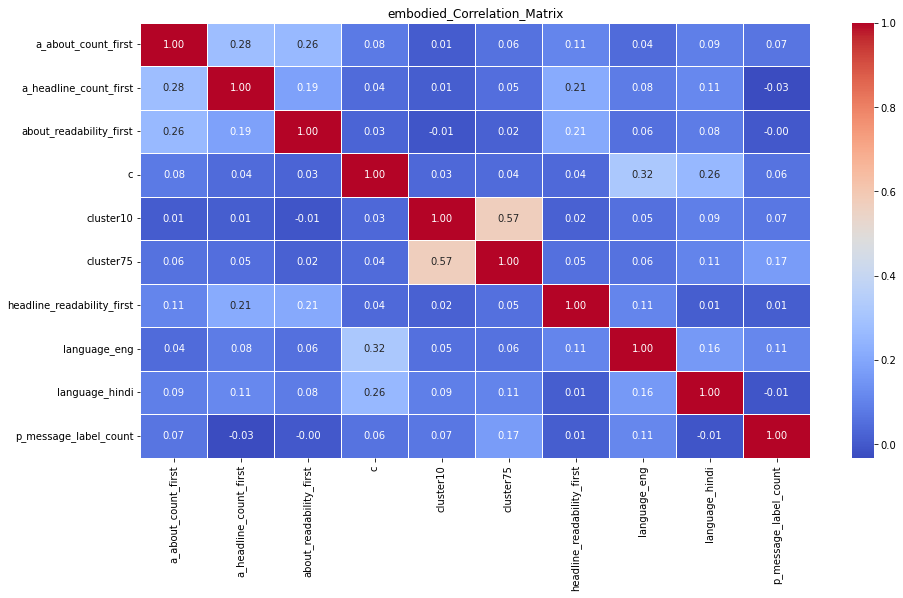

In [99]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt


# # 定义自变量和因变量
# X = embodied_df.drop(columns=["cluster","link"])  # 自变量
# # X = embodied_df.drop(columns=["link"])  # 自变量
# # y = embodied_df["cluster"]  # 因变量

# # 计算相关系数矩阵
# correlation_matrix = X.corr()

# # 绘制相关系数矩阵图
# plt.figure(figsize=(15, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# # plt.xticks(rotation=45)
# plt.title("embodied_Correlation_Matrix")
# plt.show()


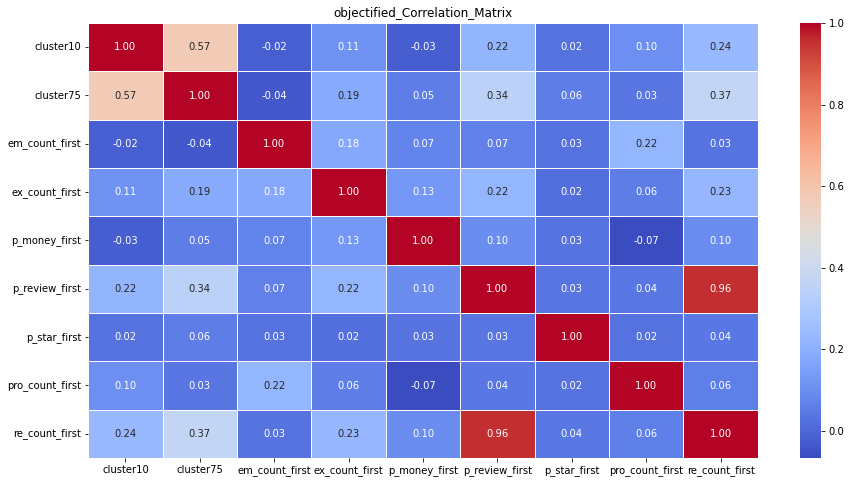

In [100]:

# # 定义自变量和因变量
# X = objectified_df.drop(columns=["cluster","link"])  # 自变量
# y = objectified_df["cluster"]  # 因变量

# # 计算相关系数矩阵
# correlation_matrix = X.corr()

# # 绘制相关系数矩阵图
# plt.figure(figsize=(15, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# # plt.xticks(rotation=45)
# plt.title("objectified_Correlation_Matrix")
# plt.show()


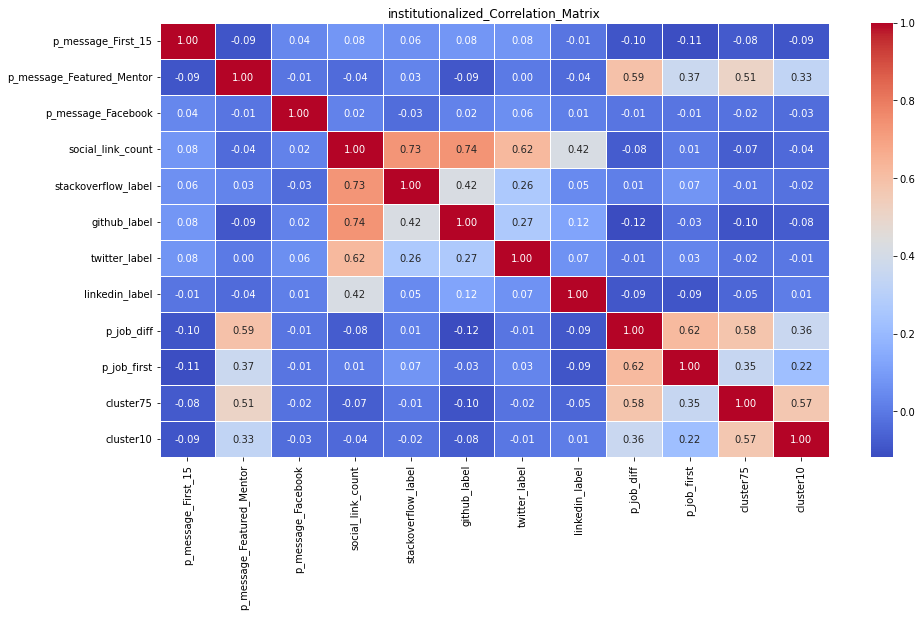

In [101]:

# # 定义自变量和因变量
# X = institutionalized_df.drop(columns=["cluster","link"])  # 自变量
# y = institutionalized_df["cluster"]  # 因变量

# # 计算相关系数矩阵
# correlation_matrix = X.corr()

# # 绘制相关系数矩阵图
# plt.figure(figsize=(15, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# # plt.xticks(rotation=15)
# plt.title("institutionalized_Correlation_Matrix")
# plt.show()


<h1 align='center'>embodied 資本 PCA分析</h1>

In [102]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# 提取特征列
# 提取特征列
# features = embodied_df.columns[1:]  # 假设第一列是链接，我们不使用链接进行PCA
features = embodied_df.columns.drop(['cluster','link'])
# 对数据进行标准化处理
scaler = StandardScaler()
embodied_scaled_data = scaler.fit_transform(embodied_df[features])

# 应用PCA
embodied_pca = PCA()
embodied_pca.fit(embodied_scaled_data)

# 获取每个主成分的解释方差比例
explained_variance_ratio = embodied_pca.explained_variance_ratio_.round(3)

# 创建DataFrame来存储主成分及其解释方差比例
embodied_pc_df = pd.DataFrame({'Principal Component': range(1, len(explained_variance_ratio) + 1),
                      'Explained Variance Ratio': explained_variance_ratio})

# 按照解释方差比例由高到低排序
embodied_pc_df = embodied_pc_df.sort_values(by='Explained Variance Ratio', ascending=False)

# 打印排名表格
embodied_pc_df

,Principal Component,Explained Variance Ratio
0,1,0.191
1,2,0.155
2,3,0.131
3,4,0.102
4,5,0.094
5,6,0.081
6,7,0.075
7,8,0.068
8,9,0.061
9,10,0.042


<h3>匯出embodied_df</h3>

In [103]:
# embodied_df.to_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\embodied_df.csv", index=False)

In [104]:
embodied_loadings = pd.DataFrame(embodied_pca.components_, columns=features)

# 打印主成分载荷矩阵
embodied_loadings

,a_about_count_first,a_headline_count_first,about_readability_first,c,cluster10,cluster75,headline_readability_first,language_eng,language_hindi,p_message_label_count
0,0.337548,0.336118,0.295313,0.320830,0.328738,0.380560,0.274855,0.335477,0.334899,0.172635
1,0.305841,0.330293,0.352334,0.028423,-0.545851,-0.518964,0.255156,0.027342,0.013021,-0.197793
2,0.226177,0.229347,0.252074,-0.570771,0.240275,0.258669,0.210733,-0.473021,-0.332891,-0.057510
3,0.063914,-0.142584,0.032186,-0.038744,-0.182960,-0.051615,0.191771,0.217268,-0.461682,0.799861
4,-0.524912,-0.006678,-0.052114,-0.005488,0.092818,0.021770,0.692582,0.290300,-0.227706,-0.311116
5,-0.110840,-0.657218,0.721919,0.025873,0.033115,-0.000614,0.035617,-0.089340,0.151498,-0.025387
6,-0.307012,0.096456,-0.127975,-0.205274,-0.158409,-0.044757,0.324489,-0.378488,0.639328,0.391844
7,0.356411,-0.303743,-0.298636,0.528244,-0.001794,0.031818,0.385630,-0.494183,-0.117240,-0.069270
8,0.476312,-0.413075,-0.307570,-0.497091,-0.014669,-0.026891,0.205165,0.367491,0.256964,-0.129180
9,0.036134,0.028748,-0.005594,0.001301,0.683921,-0.715586,0.033650,-0.031278,0.019714,0.124596


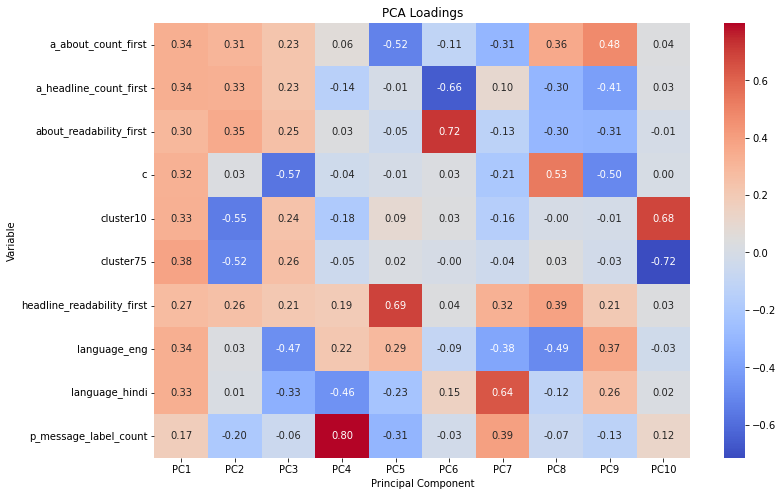

In [105]:
X = embodied_df.drop(columns=["cluster","link"])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
pca = PCA()
pca.fit(scaled_data)

# 获取成分加载
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=X.columns)

# 绘制成分加载的热力图
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA Loadings')
plt.xlabel('Principal Component')
plt.ylabel('Variable')
plt.show()

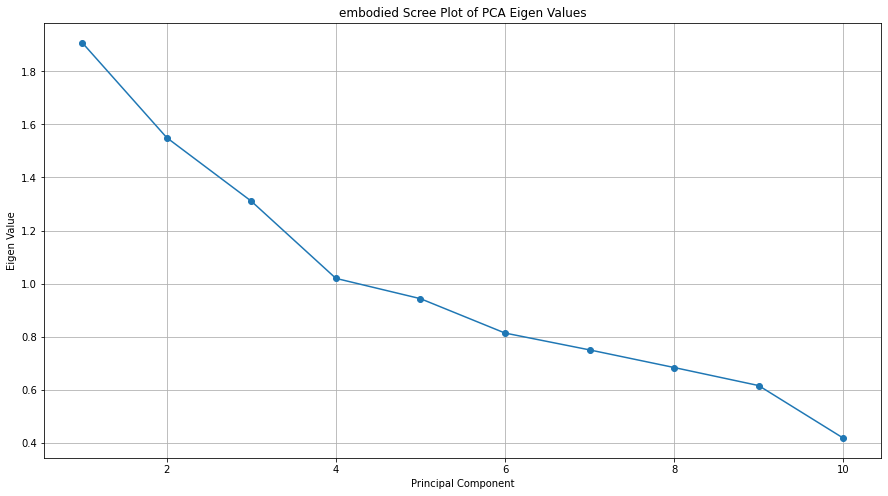

In [106]:
import numpy as np

# 提取PCA模型的explained variance
eigen_values = embodied_pca.explained_variance_

# 將eigen value繪製成圖表
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o', linestyle='-')
plt.title('embodied Scree Plot of PCA Eigen Values')
plt.xlabel('Principal Component')
plt.ylabel('Eigen Value')
plt.grid(True)
plt.show()


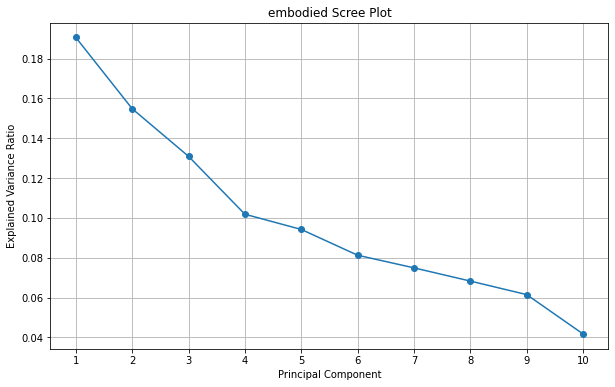

In [107]:
X = embodied_df.drop(columns=["cluster","link"])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
pca = PCA()
pca.fit(scaled_data)

# 绘制 Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('embodied Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, pca.n_components_ + 1))
plt.grid(True)
plt.show()

<h1 align='center'>objectified 資本 PCA分析</h1>

In [108]:
# features = objectified_df.columns[1:]  # 假设第一列是链接，我们不使用链接进行PCA
features = objectified_df.columns.drop(['cluster', 'link'])
# 对数据进行标准化处理
scaler = StandardScaler()
objectified_scaled_data = scaler.fit_transform(objectified_df[features])

# 应用PCA
objectified_pca = PCA()
objectified_pca.fit(objectified_scaled_data)

# 获取每个主成分的解释方差比例
objectified_explained_variance_ratio = objectified_pca.explained_variance_ratio_.round(3)

# 创建DataFrame来存储主成分及其解释方差比例
objectified_pc_df = pd.DataFrame({'Principal Component': range(1, len(objectified_explained_variance_ratio) + 1),
                      'Explained Variance Ratio': objectified_explained_variance_ratio})

# 按照解释方差比例由高到低排序
objectified_pc_df = objectified_pc_df.sort_values(by='Explained Variance Ratio', ascending=False)

# 打印排名表格
objectified_pc_df

,Principal Component,Explained Variance Ratio
0,1,0.280
1,2,0.143
2,3,0.134
3,4,0.115
4,5,0.110
5,6,0.090
6,7,0.078
7,8,0.045
8,9,0.005


<h3>匯出objectified_df</h3>

In [109]:
# objectified_df.to_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\objectified_df.csv", index=False)

In [110]:
objectified_loadings = pd.DataFrame(objectified_pca.components_, columns=features)

# 打印主成分载荷矩阵
objectified_loadings

,cluster10,cluster75,em_count_first,ex_count_first,p_money_first,p_review_first,p_star_first,pro_count_first,re_count_first
0,0.347851,0.426211,0.069047,0.261221,0.102864,0.545449,0.056600,0.084232,0.553124
1,-0.330270,-0.307862,0.671042,0.341915,0.234636,0.054574,0.071059,0.405904,0.033148
2,-0.499971,-0.314068,-0.222411,-0.009142,0.356138,0.316115,-0.076557,-0.529007,0.298945
3,-0.196776,-0.247885,-0.018031,-0.303957,-0.633871,0.292078,-0.380908,0.308493,0.282411
4,0.130431,0.098845,0.069046,0.272828,0.188531,-0.110895,-0.908365,-0.088533,-0.114928
5,-0.089839,-0.036082,0.011897,0.695523,-0.588337,-0.041406,0.119024,-0.377089,-0.050166
6,0.137784,0.104882,0.698765,-0.400677,-0.144306,0.047313,-0.018535,-0.545706,-0.000290
7,0.661180,-0.735590,-0.032211,0.060151,0.056670,0.070597,0.033677,-0.069884,0.053658
8,-0.001936,-0.017722,0.030401,-0.006112,-0.004302,-0.702164,-0.004841,-0.020433,0.710793


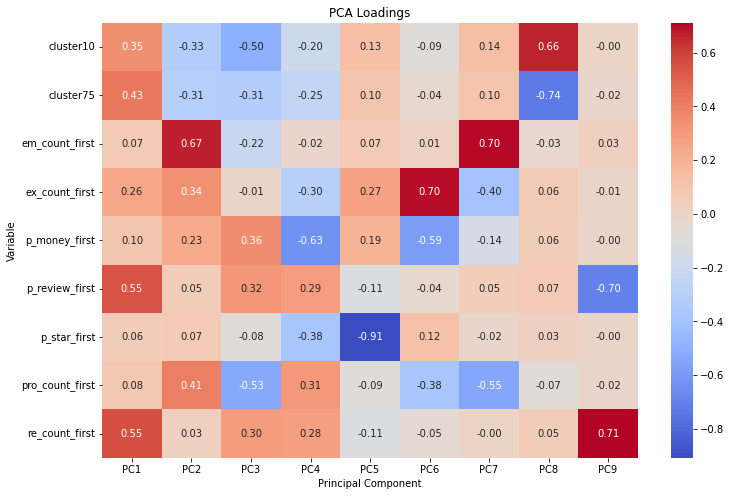

In [111]:
X = objectified_df.drop(columns=["cluster","link"])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
objectified_pca = PCA()
objectified_pca.fit(scaled_data)

# 获取成分加载
loadings = pd.DataFrame(objectified_pca.components_.T, columns=[f'PC{i+1}' for i in range(objectified_pca.n_components_)], index=X.columns)

# 绘制成分加载的热力图
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA Loadings')
plt.xlabel('Principal Component')
plt.ylabel('Variable')
plt.show()

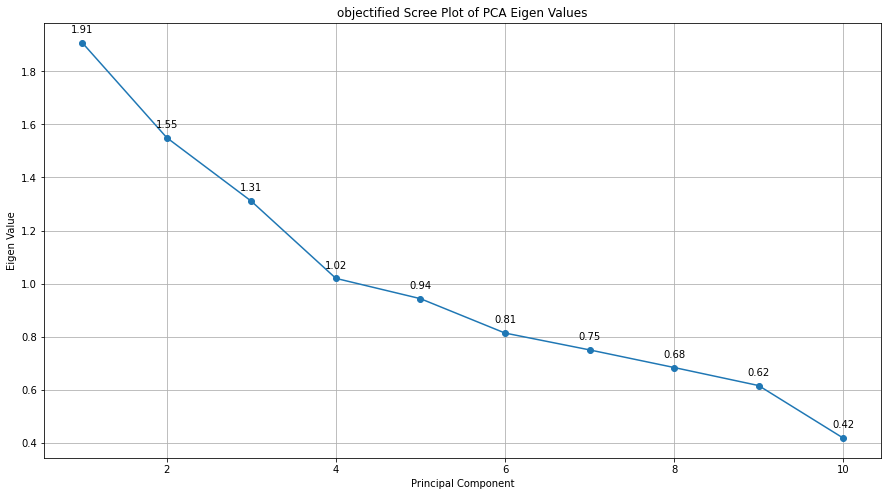

In [112]:
X = objectified_df.drop(columns=["cluster","link"])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
objectified_pca = PCA()
objectified_pca.fit(scaled_data)

# 绘制 Scree plot
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o', linestyle='-')
plt.title('objectified Scree Plot of PCA Eigen Values')
plt.xlabel('Principal Component')
plt.ylabel('Eigen Value')
plt.grid(True)

# 添加數值標籤
for i, (x, y) in enumerate(zip(range(1, len(eigen_values) + 1), eigen_values)):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


<h1 align='center'>institutional 資本 PCA分析</h1>

In [113]:
# features = institutionalized_df.columns[1:]  # 假设第一列是链接，我们不使用链接进行PCA
features = institutionalized_df.columns.drop(['cluster', 'link','p_job_diff'])
# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(institutionalized_df[features])

# 应用PCA
institutional_pca = PCA()
institutional_pca.fit(scaled_data)

# 获取每个主成分的解释方差比例
institutionalized_explained_variance_ratio = pca.explained_variance_ratio_.round(3)

# 创建DataFrame来存储主成分及其解释方差比例
institutionalized_pc_df = pd.DataFrame({'Principal Component': range(1, len(institutionalized_explained_variance_ratio) + 1),
                      'Explained Variance Ratio': institutionalized_explained_variance_ratio})

# 按照解释方差比例由高到低排序
institutionalized_pc_df = institutionalized_pc_df.sort_values(by='Explained Variance Ratio', ascending=False)

# 打印排名表格
institutionalized_pc_df

,Principal Component,Explained Variance Ratio
0,1,0.191
1,2,0.155
2,3,0.131
3,4,0.102
4,5,0.094
5,6,0.081
6,7,0.075
7,8,0.068
8,9,0.061
9,10,0.042


<h3>匯出institutionalized_df</h3>

In [114]:
# institutionalized_df.to_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\institutionalized_df.csv", index=False)

In [115]:
institutionalized_loadings = pd.DataFrame(institutional_pca.components_, columns=features)

# 打印主成分载荷矩阵
institutionalized_loadings

,p_message_First_15,p_message_Featured_Mentor,p_message_Facebook,social_link_count,stackoverflow_label,github_label,twitter_label,linkedin_label,p_job_first,cluster75,cluster10
0,-0.108793,0.137637,-0.027848,-0.583676,-0.425269,-0.459497,-0.365194,-0.212748,0.082251,0.173294,0.142657
1,-0.113778,0.481970,-0.026719,0.172457,0.185712,0.078348,0.140963,0.018521,0.411252,0.532234,0.459415
2,0.497293,0.052224,0.281775,-0.088428,0.150825,0.042003,0.176243,-0.736313,0.204378,-0.004396,-0.152432
3,0.199448,0.036095,0.836281,0.013770,-0.247147,-0.088205,0.119936,0.364319,-0.133693,0.094215,0.128985
4,-0.779661,-0.000932,0.398646,0.008478,0.058519,0.052170,0.056363,-0.213559,0.281277,-0.176522,-0.260635
5,0.243294,0.211147,0.096472,-0.004294,0.182107,0.136113,-0.639182,0.306010,0.447856,-0.102555,-0.349173
6,0.122180,0.174014,-0.210320,0.012824,-0.285938,-0.366785,0.548641,0.255703,0.416162,-0.157181,-0.360295
7,0.068012,-0.705355,-0.010183,-0.012982,-0.217220,0.178283,-0.008471,0.040871,0.551508,-0.008488,0.335606
8,-0.003998,0.263460,-0.084093,-0.021738,-0.641952,0.693632,0.022429,-0.088506,-0.054707,0.037458,-0.130643
9,0.038380,0.320825,0.010543,-0.008838,-0.009081,0.013656,-0.011740,-0.036427,0.066457,-0.780967,0.528536


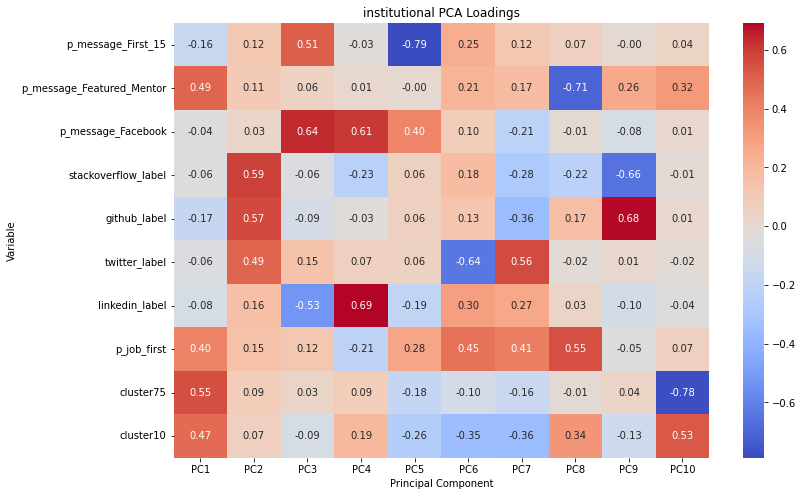

In [116]:
X = institutionalized_df.drop(columns=["cluster","link",'p_job_diff','social_link_count'])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
institutional_pca = PCA()
institutional_pca.fit(scaled_data)

# 获取成分加载
loadings = pd.DataFrame(institutional_pca.components_.T, columns=[f'PC{i+1}' for i in range(institutional_pca.n_components_)], index=X.columns)

# 绘制成分加载的热力图
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('institutional PCA Loadings')
plt.xlabel('Principal Component')
plt.ylabel('Variable')
plt.show()

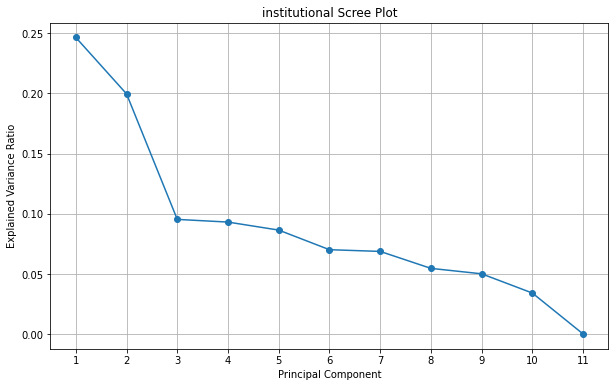

In [117]:
X = institutionalized_df.drop(columns=["cluster","link",'p_job_diff'])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
institutional_pca = PCA()
institutional_pca.fit(scaled_data)

# 绘制 Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, institutional_pca.n_components_ + 1), institutional_pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('institutional Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, institutional_pca.n_components_ + 1))
plt.grid(True)
plt.show()

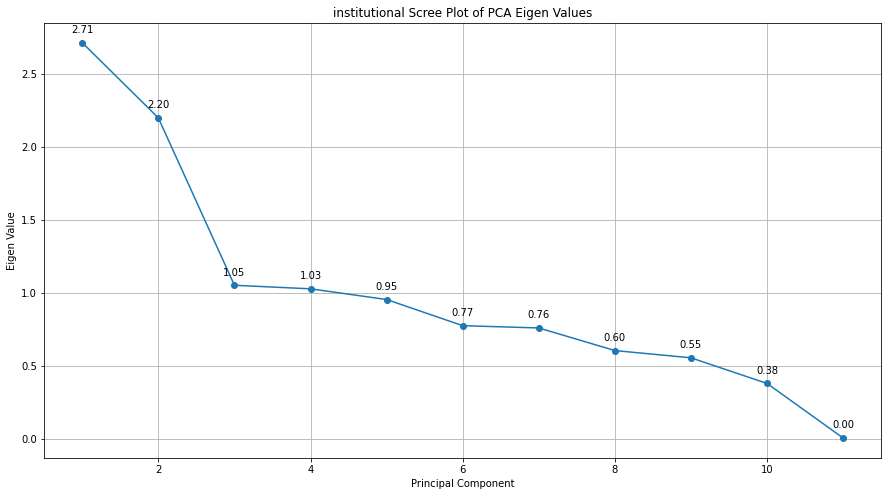

In [118]:
import numpy as np

# 提取PCA模型的explained variance
eigen_values = institutional_pca.explained_variance_

# 將eigen value繪製成圖表
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o', linestyle='-')
plt.title('institutional Scree Plot of PCA Eigen Values')
plt.xlabel('Principal Component')
plt.ylabel('Eigen Value')
plt.grid(True)

# 添加數值標籤
for i, (x, y) in enumerate(zip(range(1, len(eigen_values) + 1), eigen_values)):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()



<h1 align='center'>merged_data PCA分析</h1>

In [119]:
merged_df = pd.merge(institutionalized_df, objectified_df, on='link', how='inner')

# 再將 embodied_df 合併
merged_df = pd.merge(merged_df, embodied_df, on='link', how='inner')

In [120]:
# features = institutionalized_df.columns[1:]  # 假设第一列是链接，我们不使用链接进行PCA
features = merged_df.columns.drop(['cluster', 'link','p_job_diff','cluster_x','cluster_y'])
# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df[features])

# 应用PCA
merged_pca = PCA()
merged_pca.fit(scaled_data)

# 获取每个主成分的解释方差比例
merged_explained_variance_ratio = pca.explained_variance_ratio_.round(3)

# 创建DataFrame来存储主成分及其解释方差比例
merged_pc_df = pd.DataFrame({'Principal Component': range(1, len(merged_explained_variance_ratio) + 1),
                      'Explained Variance Ratio': merged_explained_variance_ratio})
# # 按照解释方差比例由高到低排序
merged_pc_df = merged_pc_df.sort_values(by='Explained Variance Ratio', ascending=False)

# 打印排名表格
merged_pc_df

,Principal Component,Explained Variance Ratio
0,1,0.191
1,2,0.155
2,3,0.131
3,4,0.102
4,5,0.094
5,6,0.081
6,7,0.075
7,8,0.068
8,9,0.061
9,10,0.042


<h2>匯出檔案</h2>


In [121]:
from datetime import datetime
# 獲取當前日期和時間
current_datetime = datetime.now()
# 將日期和時間格式化為字符串
current_datetime = current_datetime.strftime("%Y%m%d_%H%M")
current_datetime = str(current_datetime)

# 將 'p_job_first' 和 'p_job_diff' 列取對數
merged_df[['log_p_job_first', 'log_p_job_diff']] = np.log(merged_df[['p_job_first', 'p_job_diff']])
# merged_df.drop(columns=['cluster_x', 'cluster_y'], inplace=True)
merged_df['log_p_job_diff'] = np.log1p(merged_df['p_job_diff'])
file_path = r"C:\Users\Modern 14\Desktop\codementorAll\test\merged_df_" + current_datetime + ".csv"
merged_df.to_csv(file_path, index=False)

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [122]:
# embodied_file_name = f"C:\\Users\\Modern 14\\Desktop\\codementorAll\\test\\output\\embodied_df_{current_datetime}.csv"
# embodied_df.to_csv(embodied_file_name, index=False)

# objectified_file_name = f"C:\\Users\\Modern 14\\Desktop\\codementorAll\\test\\output\\objectified_{current_datetime}.csv"
# objectified_df.to_csv(objectified_file_name, index=False)

# institutionalized_file_name = f"C:\\Users\\Modern 14\\Desktop\\codementorAll\\test\\output\\institutionalized_{current_datetime}.csv"
# institutionalized_df.to_csv(institutionalized_file_name, index=False)

In [123]:
merged_loadings = pd.DataFrame(merged_pca.components_, columns=features)

# 打印主成分载荷矩阵
merged_loadings

,p_message_First_15,p_message_Featured_Mentor,p_message_Facebook,social_link_count,stackoverflow_label,github_label,twitter_label,linkedin_label,p_job_first,cluster75_x,...,a_about_count_first,a_headline_count_first,about_readability_first,c,cluster10,cluster75,headline_readability_first,language_eng,language_hindi,p_message_label_count
0,-0.045881,2.526297e-01,-1.169359e-02,-1.893305e-02,1.224401e-02,-4.266450e-02,4.674644e-03,-2.303998e-02,2.570711e-01,0.358576,...,6.499690e-02,3.840524e-02,8.548372e-03,2.301901e-02,0.321096,0.358576,2.800024e-02,5.238465e-02,4.679513e-02,8.186208e-02
1,0.098627,-1.273775e-02,2.917054e-02,4.823187e-01,3.704554e-01,3.609535e-01,3.227047e-01,1.501636e-01,1.126048e-01,-0.053521,...,1.709645e-01,1.486797e-01,1.190181e-01,1.648049e-01,-0.082864,-0.053521,1.096570e-01,2.007458e-01,9.487527e-02,9.144091e-02
2,-0.073827,6.471741e-02,2.681509e-03,-1.752425e-01,-8.109062e-02,-1.304882e-01,-1.027452e-01,-1.562362e-01,4.323465e-01,-0.092916,...,1.581264e-01,4.652480e-02,-2.016471e-02,-1.183482e-01,-0.281036,-0.092916,1.057256e-02,-4.217170e-02,-1.327192e-01,-2.326718e-02
3,0.624001,1.775819e-01,8.859635e-02,-5.109066e-02,-6.734440e-03,-3.787150e-02,1.613563e-02,-1.065053e-01,-2.962315e-02,0.052469,...,-3.392283e-02,-1.262591e-01,-8.100304e-02,5.466121e-02,-0.090116,0.052469,-3.546221e-02,8.269127e-02,-4.072926e-02,6.620071e-01
4,0.077187,-6.730943e-02,3.783225e-02,-2.426759e-01,-1.970920e-01,-2.270149e-01,-1.055633e-01,-6.250235e-02,-1.411189e-01,0.047454,...,3.425161e-01,4.227589e-01,4.124881e-01,1.058459e-01,-0.037409,0.047454,3.325766e-01,8.956838e-02,1.569341e-01,3.903377e-02
5,0.186258,-6.322587e-02,8.329343e-02,2.617745e-02,-6.175928e-02,3.259246e-02,-6.546350e-02,1.976840e-01,5.516580e-02,-0.185100,...,1.038250e-01,8.460112e-02,1.153468e-01,-4.508969e-01,0.207548,-0.185100,3.369685e-02,-3.687679e-01,-3.404059e-01,1.512154e-01
6,0.078407,-1.101764e-01,2.341104e-02,-1.308765e-01,-1.512569e-01,-1.405534e-01,-4.429802e-02,2.786535e-02,1.464851e-01,-0.265601,...,5.462196e-02,-4.536787e-02,-6.818920e-02,3.743693e-01,0.177460,-0.265601,-1.271504e-01,2.911431e-01,3.800271e-01,2.487483e-02
7,0.055228,-1.789285e-01,-5.796226e-02,-3.692202e-02,1.368023e-01,2.502504e-02,1.154320e-01,-4.682570e-01,2.123772e-02,-0.171330,...,-2.352710e-02,-4.980781e-02,-3.521769e-02,3.140855e-02,0.222161,-0.171330,2.066140e-01,2.082457e-01,-2.627579e-01,-3.904611e-02
8,-0.153320,1.463185e-02,7.048923e-01,4.729510e-02,-7.621194e-03,6.143804e-03,1.954300e-01,-8.957747e-02,-1.674270e-02,0.047390,...,5.754004e-02,-2.747736e-02,3.777516e-02,1.251885e-02,-0.019320,0.047390,-1.890061e-01,-3.912174e-02,2.402277e-02,-8.977503e-02
9,0.001911,-3.856869e-02,3.620687e-01,-1.882112e-02,-2.548997e-01,-7.460361e-02,-8.303511e-03,4.097726e-01,1.106816e-03,-0.029494,...,-2.834695e-01,2.064780e-01,-3.990587e-01,7.926189e-02,0.026300,-0.029494,1.333261e-02,1.693626e-01,-1.202901e-01,2.963006e-03


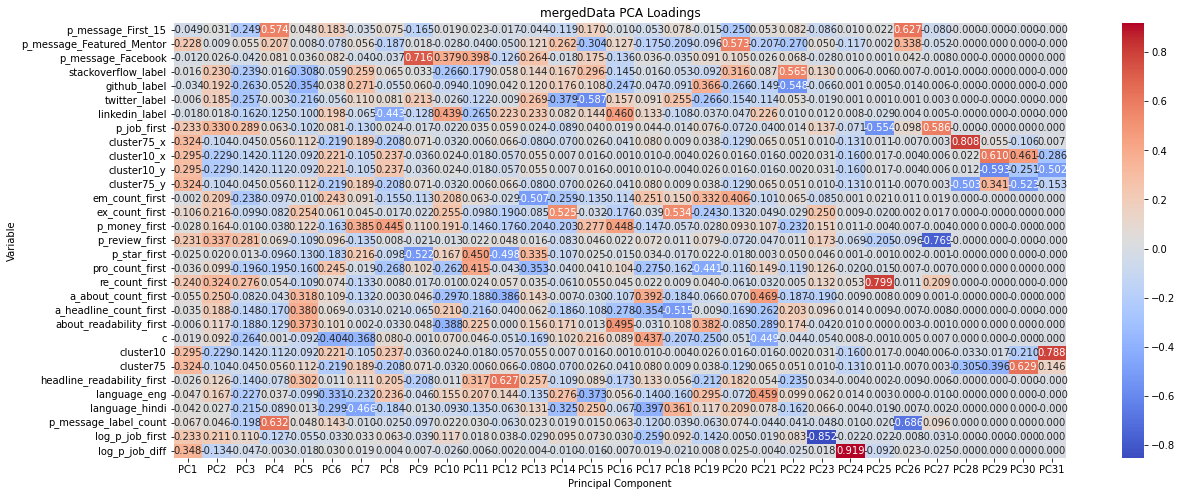

In [124]:
merged_df['log_p_job_diff'] = np.log1p(merged_df['p_job_diff'])
X = merged_df.drop(columns=["cluster","link",'p_job_diff','social_link_count','cluster_x','cluster_y'])  # 自变量

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# 应用PCA
merged_pca = PCA()
merged_pca.fit(scaled_data)

# 获取成分加载
loadings = pd.DataFrame(merged_pca.components_.T, columns=[f'PC{i+1}' for i in range(merged_pca.n_components_)], index=X.columns)

# 绘制成分加载的热力图
plt.figure(figsize=(20, 8))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt=".3f")
plt.title('mergedData PCA Loadings')
plt.xlabel('Principal Component')
plt.ylabel('Variable')
plt.show()

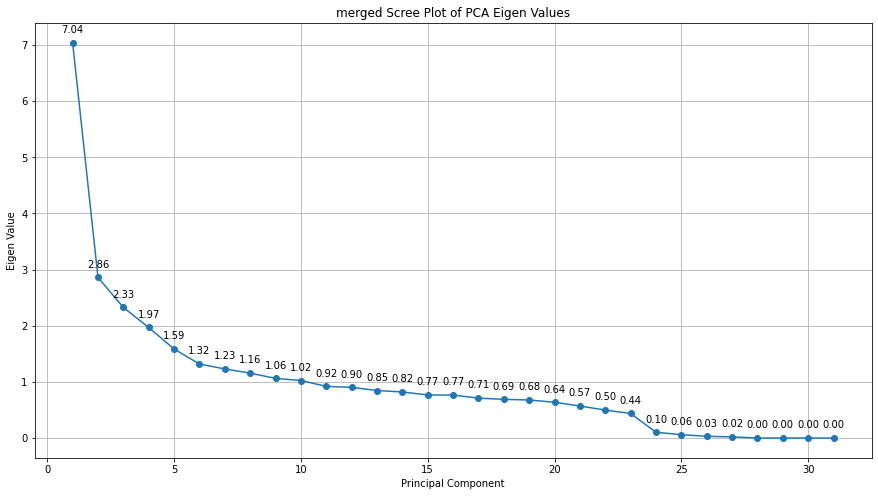

In [125]:
import numpy as np

# 提取PCA模型的explained variance
eigen_values = merged_pca.explained_variance_

# 將eigen value繪製成圖表
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o', linestyle='-')
plt.title('merged Scree Plot of PCA Eigen Values')
plt.xlabel('Principal Component')
plt.ylabel('Eigen Value')
plt.grid(True)

# 添加數值標籤
for i, (x, y) in enumerate(zip(range(1, len(eigen_values) + 1), eigen_values)):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()



<h1 align='center'>discrimnant analysis</h1>

In [126]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# np.set_printoptions(suppress=True, precision=3)

<h1>merged_pca_df 區別分析</h1>

In [127]:
merged_pca_df = pd.read_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\Merge_Sep_02.csv")

In [128]:
merged_pca_df.columns.tolist()

['cluster',
 'link',
 'Language2',
 'Introduction2',
 'Label2',
 'Review2',
 'EM_PROJ2',
 'Expertise2',
 'Money2',
 'Internal2',
 'Extenal2']

c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-pac

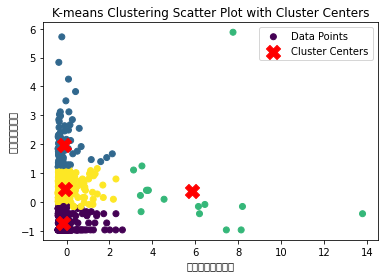

In [129]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 選擇要標準化的特徵
# selected_features = ['Language2', 'Introduction2', 'Label2', 'Review2', 'EM_PROJ2', 'Expertise2', 'Money2', 'Internal2',
#                      'Extenal2']

selected_features = ['Review2', 'EM_PROJ2']

# 創建 StandardScaler 對象
scaler = StandardScaler()

# 對選擇的特徵進行標準化
scaled_features = scaler.fit_transform(merged_pca_df[selected_features])

# K-means叢集分析
kmeans = KMeans(n_clusters=4, random_state=42)
merged_pca_df['cluster'] = kmeans.fit_predict(scaled_features)

# 繪製散點圖
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=merged_pca_df['cluster'], cmap='viridis', label='Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.title('K-means Clustering Scatter Plot with Cluster Centers')
plt.xlabel('標準化第一期基數')
plt.ylabel('標準化成長比例')
plt.legend()
plt.show()


In [130]:

# 定義自變量和因變量
X = merged_pca_df.drop(columns=['link', 'cluster'])  # 自變量
y = merged_pca_df['cluster']  # 因變量
features = X.columns
LDA=LinearDiscriminantAnalysis(n_components=3)
lda_x=LDA.fit_transform(X,y)

LDA.explained_variance_ratio_
np.cumsum(LDA.explained_variance_ratio_)

array([0.64708246, 0.99549866, 1.        ])

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 21312 (\N{CJK UNIFIED IDEOGRAPH-5340}) missing from current font.
  func(*args, **kwargs)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from current font.
  func(*args, **kwargs)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  func(*args, **kwargs)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26512 (\N{CJK UNIFIED IDEOGRAPH-6790}) missing from current font.
  func(*args, **kwargs)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from current font.
  func(*args, **kwa

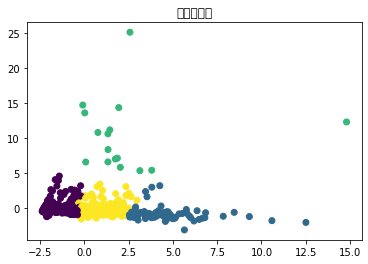

In [131]:
plt.title('區別分析圖')
plt.scatter(lda_x[:,0], lda_x[:,1], c = y)

explained variance ratio (first two components): [0.63322959 0.31122016 0.01360598]


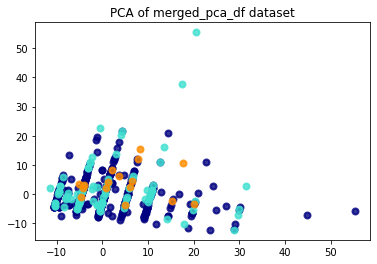

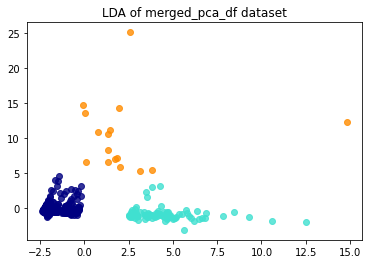

In [132]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


X = merged_pca_df.drop(columns=['link', 'cluster'])  # 自變量
y = merged_pca_df['cluster']  # 因變量
target_names = merged_pca_df.columns

pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=3)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of merged_pca_df dataset")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of merged_pca_df dataset")

plt.show()

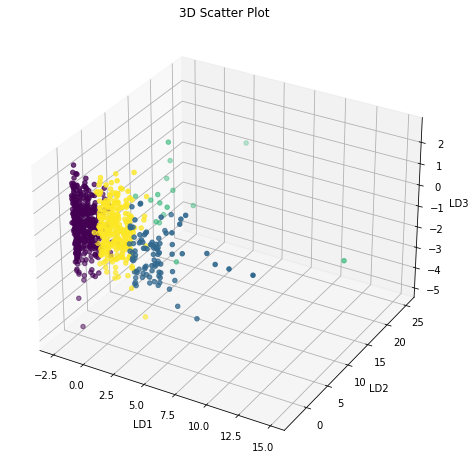

In [133]:
from mpl_toolkits.mplot3d import Axes3D

# 创建一个大尺寸的三维图形对象
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图
ax.scatter(lda_x[:, 0], lda_x[:, 1], lda_x[:, 2], c=y, cmap='viridis')

# 设置图形标题和轴标签
ax.set_title('3D Scatter Plot')
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
ax.set_zlabel('LD3')

# 显示图形
plt.show()


In [134]:
# 提取LDA模型的主成分係數
components = LDA.coef_

# 創建包含係數的DataFrame

merged_component_df = pd.DataFrame(components, columns=features, index=[f'LD{i+1}' for i in range(components.shape[0])])

# 印出主成分係數
merged_component_df



,Language2,Introduction2,Label2,Review2,EM_PROJ2,Expertise2,Money2,Internal2,Extenal2
LD1,-0.009764,-0.082831,-0.099776,-0.447205,-3.563267,0.004399,-0.001763,-0.052142,-0.043894
LD2,-0.258211,0.103572,0.529471,-0.528124,9.886530,0.023652,0.039370,0.365359,-0.111037
LD3,-0.811729,0.780926,-2.223128,19.925434,1.926250,-0.323787,-0.027169,-2.369794,0.449174
LD4,0.151164,0.052739,0.107475,-0.249754,2.235295,0.003508,-0.009094,0.095534,0.082810


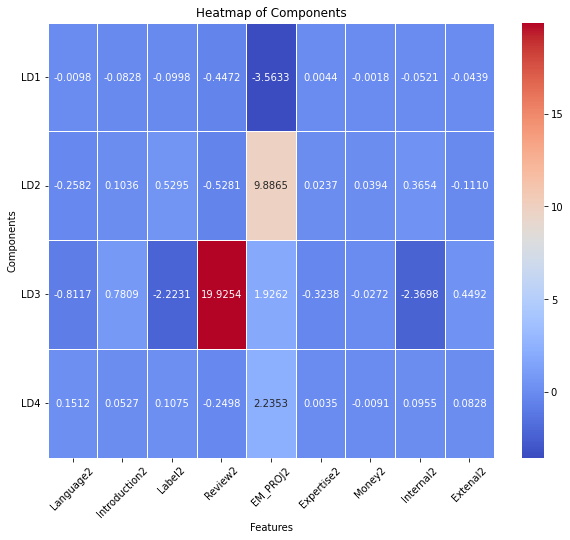

In [135]:
# 创建热力图
plt.figure(figsize=(10, 8))
sns.heatmap(merged_component_df, cmap='coolwarm', annot=True, fmt=".4f", linewidths=0.5)
plt.title('Heatmap of Components')
plt.xlabel('Features')
plt.ylabel('Components')
plt.xticks(rotation=45)  # 旋转 x 轴标签以便于阅读
plt.yticks(rotation=0)   # 旋转 y 轴标签以便于阅读
plt.show()


In [136]:
# 創建係數和變數名稱的對應表
coef_df_1 = pd.DataFrame({'Feature': features, 'Coefficient_1': LDA.coef_[0]})
coef_df_2 = pd.DataFrame({'Feature': features, 'Coefficient_2': LDA.coef_[1]})
coef_df_3 = pd.DataFrame({'Feature': features, 'Coefficient_3': LDA.coef_[2]})
coef_df_4 = pd.DataFrame({'Feature': features, 'Coefficient_4': LDA.coef_[3]})

# 合併所有係數和變數名稱的對應表
all_coef_df = pd.merge(coef_df_1, coef_df_2, on='Feature')
all_coef_df = pd.merge(all_coef_df, coef_df_3, on='Feature')
all_coef_df = pd.merge(all_coef_df, coef_df_4, on='Feature')

# 印出係數和變數名稱對應表
all_coef_df.round(3)


,Feature,Coefficient_1,Coefficient_2,Coefficient_3,Coefficient_4
0,Language2,-0.010,-0.258,-0.812,0.151
1,Introduction2,-0.083,0.104,0.781,0.053
2,Label2,-0.100,0.529,-2.223,0.107
3,Review2,-0.447,-0.528,19.925,-0.250
4,EM_PROJ2,-3.563,9.887,1.926,2.235
5,Expertise2,0.004,0.024,-0.324,0.004
6,Money2,-0.002,0.039,-0.027,-0.009
7,Internal2,-0.052,0.365,-2.370,0.096
8,Extenal2,-0.044,-0.111,0.449,0.083


In [137]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm


# # 定义自变量和因变量
# X = merged_df.drop(columns=["p_job_diff","link","cluster_x",'cluster_y'])  # 自变量
# y = merged_df["cluster"]  # 因变量

# # 前向逐步选择
# def forward_stepwise_selection(X, y):
#     initial_features = X.columns.tolist()
#     best_features = []
#     all_features = []
#     while (len(initial_features)>0):
#         remaining_features = list(set(initial_features)-set(best_features))
#         new_pval = pd.Series(index=remaining_features)
#         for new_column in remaining_features:
#             model = sm.OLS(y, sm.add_constant(X[best_features+[new_column]])).fit()
#             new_pval[new_column] = model.pvalues[new_column]
#         min_p_value = new_pval.min()
#         if(min_p_value<0.05):
#             best_feature = new_pval.idxmin()
#             best_features.append(best_feature)
#             all_features.append(best_features.copy())
#         else:
#             break
#     return all_features

# selected_features_history = forward_stepwise_selection(X, y)
# for i, features in enumerate(selected_features_history):
#     print(f"Step {i+1}: {features}")

In [138]:
# import statsmodels.api as sm


# # 定义自变量和因变量
# X = institutionalized_df.drop(columns=["p_job_diff","link","cluster"])  # 自变量
# y = institutionalized_df["cluster"]  # 因变量

# # 后向逐步选择
# def backward_stepwise_selection(X, y):
#     features = X.columns.tolist()
#     while (len(features) > 0):
#         X_subset = X[features]
#         model = sm.OLS(y, sm.add_constant(X_subset)).fit()
#         p_values = model.pvalues.drop('const')
#         max_p_value = p_values.max()
#         if max_p_value > 0.05:
#             remove_feature = p_values.idxmax()
#             features.remove(remove_feature)
#         else:
#             break
#     return features

# selected_features = backward_stepwise_selection(X, y)
# print("Selected features:", selected_features)


<h1>merged_10_df 分群</h1>

In [269]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# np.set_printoptions(suppress=True, precision=3)

In [270]:
merged_10_df = pd.read_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\dataAll\Don_20240417_new.csv")

In [271]:
merged_10_df.drop(columns=['cluster'], inplace=True)
merged_10_df

,link,Internal,External,Ability,money_standarize,code_standarized,Code,Money,Review,Introduction,...,External2,Ability2,Code2,Money2,Review2,Introduction2,Language2,Label2,logjobfirst2,logjobdiff2
0,/@_lutfor,0.403396,-0.206451,2.668080,0.061124,3.763433,31.0,20.0,0.192813,1.129700,...,0.40,0.80,1.000,0.55,0.510,0.66,0.34,0.05,0.78,0.53
1,/@0xtimc,0.403396,-0.206451,-0.632409,0.061124,-1.147656,2.0,20.0,-0.336773,-0.160649,...,0.40,0.12,0.020,0.55,0.060,0.45,0.34,0.05,0.33,0.52
2,/@11995shubham,0.403396,-1.495630,-0.475748,0.303737,-0.639613,5.0,22.0,0.061689,-1.119860,...,0.05,0.18,0.180,0.64,0.501,0.19,0.79,0.05,0.70,0.81
3,/@a.k,0.403396,-1.495630,-0.956194,0.425043,1.223214,16.0,23.0,0.906164,1.612670,...,0.05,0.05,0.890,0.68,0.550,0.73,0.87,0.05,0.84,0.89
4,/@aakshisharma893,-0.950631,-1.495630,-0.956194,0.061124,-0.978308,3.0,20.0,-0.337959,-2.334700,...,0.05,0.05,0.050,0.55,0.060,0.05,0.05,0.71,0.15,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,/@ziad-saab,0.403396,0.978477,1.205820,3.700311,1.392562,17.0,50.0,0.124123,-0.025156,...,0.95,0.65,0.910,1.00,0.510,0.49,0.69,0.05,0.71,0.51
899,/@zoltnorbn,-0.950631,-0.206451,-0.956194,-0.545407,-0.300917,7.0,15.0,-0.332013,-0.271707,...,0.40,0.05,0.501,0.21,0.060,0.41,0.87,0.71,0.48,0.60
900,/@zuberalam987,-0.950631,-0.206451,-0.151962,-0.545407,1.223214,16.0,15.0,-0.115235,-0.198198,...,0.40,0.38,0.890,0.21,0.280,0.44,0.34,0.71,0.59,0.23
901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [272]:
merged_10_df.dtypes

link                 object
Internal            float64
External            float64
Ability             float64
money_standarize    float64
code_standarized    float64
Code                float64
Money               float64
Review              float64
Introduction        float64
Language            float64
Label               float64
p_job_first         float64
p_job_diff          float64
cluster10           float64
cluster75           float64
cluster_x           float64
cluster75_x         float64
cluster10_x         float64
cluster_y           float64
cluster10_y         float64
cluster75_y         float64
logjobfirst         float64
logjobdiff          float64
Internal2           float64
External2           float64
Ability2            float64
Code2               float64
Money2              float64
Review2             float64
Introduction2       float64
Language2           float64
Label2              float64
logjobfirst2        float64
logjobdiff2         float64
dtype: object

In [273]:
merged_10_df.dropna(subset=selected_features, inplace=True)

In [274]:
# 選擇要標準化的特徵
# selected_features = ['Language2', 'Introduction2', 'Label2', 'Review2', 'EM_PROJ2', 'Expertise2', 'Money2', 'Internal2',
#                      'Extenal2']

selected_features =['Internal', 'External', 'Ability', 'code_standarized', 'money_standarize', 'Review',
       'Introduction', 'Language']
# selected_features = ['Review2', 'EM_PROJ2']

# 創建 StandardScaler 對象
scaler = StandardScaler()

# 對選擇的特徵進行標準化
scaled_features = scaler.fit_transform(merged_10_df[selected_features])

# K-means叢集分析
kmeans = KMeans(n_clusters=3, random_state=42)
merged_10_df['cluster_a3'] = kmeans.fit_predict(scaled_features)

kmeans = KMeans(n_clusters=4, random_state=42)
merged_10_df['cluster_a4'] = kmeans.fit_predict(scaled_features)

# # 繪製散點圖
# plt.scatter(scaled_features[:, 8], scaled_features[:, 9], c=merged_10_df['cluster'], cmap='viridis', label='Data Points')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

# plt.title('K-means Clustering Scatter Plot with Cluster Centers')
# plt.xlabel('logjobdiff2')
# plt.ylabel('logjobfirst2')
# plt.legend()
# plt.show()


c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


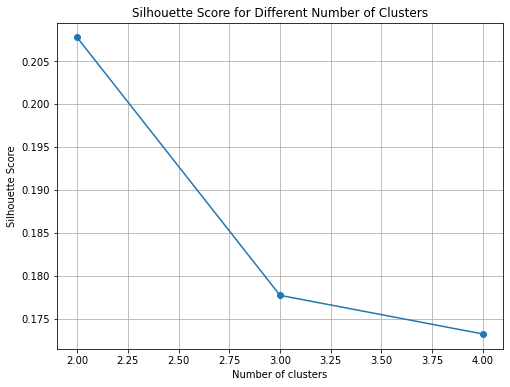

In [275]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 选择要进行聚类的特征
selected_features = ['Internal2', 'External2', 'Ability2', 'Code2', 'Money2', 'Review2', 'Introduction2', 'Language2']

# 选择聚类的范围
range_n_clusters = [2, 3, 4]

# 存储每个聚类数目的轮廓系数值
silhouette_scores = []

# 计算每个聚类数目的轮廓系数
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(merged_10_df[selected_features])
    if n_clusters > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(merged_10_df[selected_features], kmeans.labels_))

# 绘制轮廓系数图像
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters[0:], silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters')
plt.grid(True)
plt.show()


c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Modern 14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


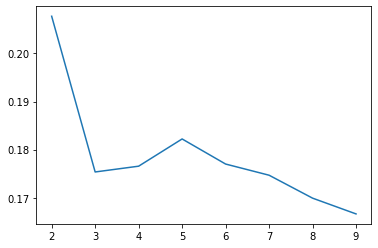

In [276]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



# 选择要进行聚类的特征
selected_features = ['Internal2', 'External2', 'Ability2', 'Code2', 'Money2', 'Review2', 'Introduction2', 'Language2']

X = merged_10_df[selected_features]

# 选择聚类的范围
silhouette_avg = []
for i in range(2,10):
    kmeans_fit = KMeans(n_clusters = i).fit(X)
    silhouette_avg.append(silhouette_score(X, kmeans_fit.labels_))
plt.plot(range(2,10), silhouette_avg)

In [277]:
current_datetime = datetime.now()
# 將日期和時間格式化為字符串
current_datetime = current_datetime.strftime("%Y%m%d_%H%M")
current_datetime = str(current_datetime)
# merged_10_df.to_csv(r"C:\Users\Modern 14\Desktop\codementorAll\test\output\merged_10_df_" + current_datetime + ".csv", index=False)

<h1>stepwise Selection</h1>

In [278]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm


# # 定义自变量和因变量
# X = diff_df.drop(columns=["p_job_diff","link","cluster"])  # 自变量
# y = diff_df["cluster"]  # 因变量

# # 前向逐步选择
# def forward_stepwise_selection(X, y):
#     initial_features = X.columns.tolist()
#     best_features = []
#     all_features = []
#     while (len(initial_features)>0):
#         remaining_features = list(set(initial_features)-set(best_features))
#         new_pval = pd.Series(index=remaining_features)
#         for new_column in remaining_features:
#             model = sm.OLS(y, sm.add_constant(X[best_features+[new_column]])).fit()
#             new_pval[new_column] = model.pvalues[new_column]
#         min_p_value = new_pval.min()
#         if(min_p_value<0.05):
#             best_feature = new_pval.idxmin()
#             best_features.append(best_feature)
#             all_features.append(best_features.copy())
#         else:
#             break
#     return all_features

# selected_features_history = forward_stepwise_selection(X, y)
# for i, features in enumerate(selected_features_history):
#     print(f"Step {i+1}: {features}")

In [279]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm

# # 加载数据到 DataFrame


# # 定义自变量和因变量
# X = diff_df.drop(columns=["p_job_diff","link"])  # 自变量
# y = diff_df["p_job_diff"]  # 因变量

# # 前向逐步选择
# def forward_stepwise_selection(X, y):
#     initial_features = X.columns.tolist()
#     best_features = []
#     while (len(initial_features) > 0):
#         remaining_features = list(set(initial_features) - set(best_features))
#         new_pval = pd.Series(index=remaining_features)
#         for new_column in remaining_features:
#             model = sm.OLS(y, sm.add_constant(X[best_features+[new_column]])).fit()
#             new_pval[new_column] = model.pvalues[new_column]
#         min_p_value = new_pval.min()
#         if(min_p_value < 0.05):
#             best_feature = new_pval.idxmin()
#             best_features.append(best_feature)
#             # 输出当前步骤的模型系数
#             print("Step:", len(best_features))
#             print(model.params)
#         else:
#             break
#     return best_features

# selected_features = forward_stepwise_selection(X, y)

In [280]:
# import pandas as pd
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# diff_df

# # 定义自变量（不包括目标变量）
# X = diff_df.drop(columns=["p_job_diff","link"])  

# # 计算 VIF
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # 打印结果
# vif_data